# Time series classification

In [150]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from reservoirpy.observables import nrmse, rsquare
from reservoirpy.nodes import Reservoir, Ridge, Input
import reservoirpy as rpy
import optuna


rpy.verbosity(0)  # no need to be too verbose here
rpy.set_seed(42)  # make everything reproducible!


In [151]:
# Set the base directory correctly to your dataset location
base_dir = 'data'
file_pattern = '**/*.sign'
files = glob.glob(os.path.join(base_dir, file_pattern), recursive=True)

# Check if files are being detected
print(f"Detected {len(files)} files.")

Sub = [
    "adam1", "adam2", "andrew1", "andrew2", "andrew3",
    "john1", "john2", "john3", "john4", "john5",
    "stephen1", "stephen2", "stephen3", "stephen4",
    "waleed1", "waleed2", "waleed3", "waleed4"
]

FEATURES = ["x", "y", "z", "roll", "thumb", "fore", "index", "ring"]

def read_data(path):
    data = {samples: [] for samples in Sub}
    classes = {c: [] for c in Sub}

    for file in path:
        sub_name = os.path.basename(os.path.dirname(file))
        sign = os.path.splitext(os.path.basename(file))[0]

        df = pd.read_csv(file, header=None, delimiter=',')
        df = df.iloc[:, :-5] #features to drop
        df = df.drop(df.columns[[4, 5]], axis=1)

        clean_data = df.to_numpy()
        updated_data = {f"{label}": clean_data[:, i] for i, label in enumerate(FEATURES)}
        data[sub_name].append(updated_data)
        classes[sub_name].append(sign)

    return data, classes

data, label = read_data(files)


Detected 6756 files.


In [152]:
def process_data_sample(data_sample):
	data_list =[]
	for i in data_sample.keys():
		data_list.append(data_sample[i])
	return np.array(data_list)

In [153]:
for i in data.keys():
	for j in range(len(label[i])):
		label[i][j] = label[i][j][:-1]

In [154]:
final_data = []
final_labels = []
for i in data.keys():
	for j in range(len(data[i])):
		final_data.append(process_data_sample(data[i][j]))
		final_labels.append(label[i][j])

In [155]:
def resample_row( original_array, target_length):

        data_array = original_array[:]

        # time points
        original_length = original_array.shape[0]
        time_points_original = np.linspace(0, 1, original_length)

        # linear interpolation
        time_points_resampled = np.linspace(0, 1, target_length)
        resampled_array = np.interp(time_points_resampled, time_points_original, data_array)
        return resampled_array

def resample_array( array, target_length):
        
        resample_array = []
        for i in array:
            j = resample_row((i).astype(float), target_length)
            resample_array.append(j)
        return np.array(resample_array)

In [156]:
mc_data = []
mc_labels = []
for i in range(len(final_labels)):
	if(final_data[i].shape[1] > 33):
		mc_data.append(resample_array(final_data[i] , 34))
		mc_labels.append(final_labels[i])

In [157]:
np_mc_data = np.array(mc_data)
np_mc_data.shape


In [159]:
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(mc_labels)
encoded_labels = encoded_labels.reshape(-1, 1)


In [160]:

np_mc_data = np.transpose(np_mc_data, axes=[0,2,1])

N_samples, N_steps, N_features = np_mc_data.shape

N_classes = len(np.unique(encoded_labels))

targets = np.zeros((N_samples, N_steps, N_classes))

for i in range(N_samples):
    targets[i,:,encoded_labels[i]] = 1.0

print(N_steps)

34


In [161]:
X_train_full, X_test, Y_train_full, Y_test, labels_train_full, labels_test = train_test_split(np_mc_data, targets, encoded_labels, test_size=0.2, stratify=encoded_labels, random_state=42, shuffle=True)

X_train, X_val, Y_train, Y_val, labels_train, labels_val = train_test_split(X_train_full, Y_train_full, labels_train_full, test_size=0.1, stratify=labels_train_full, random_state=42, shuffle=True)

In [162]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", Y_train.shape)
print("y_val shape:", Y_val.shape)
print(X_train[0].shape)


X_train shape: (4846, 34, 8)
X_val shape: (539, 34, 8)
y_train shape: (4846, 34, 98)
y_val shape: (539, 34, 98)
(34, 8)


In [294]:
reservoir = Reservoir(units=600,  # Number of units in the reservoir
                        lr=0.25,     # Leak rate
                        sr=0.27,    # Spectral radius
                        input_scaling=0.9,
                        rc_connectivity=0.2,
                        bias_scaling= 0.6)

readout = Ridge(ridge=1e-9)
source = Input()
# Building the ESN model by piping the reservoir to the readout
esn = source >> reservoir >> readout
base = source >> readout
rpy.verbosity(1)
Y_pred = base.fit(X_train, Y_train, warmup=10, force_teachers=True).run(X_test, forced_feedbacks=Y_train, shift_fb=True)


Running Model-128: 34it [00:00, 8271.35it/s]            /s]
Running Model-128: 34it [00:00, 16611.10it/s]           
Running Model-128: 34it [00:00, 16989.08it/s]           
Running Model-128: 34it [00:00, 10936.07it/s]           
Running Model-128: 34it [00:00, 11349.49it/s]           
Running Model-128: 34it [00:00, 16922.55it/s]           
Running Model-128: 34it [00:00, 11212.07it/s]           
Running Model-128: 34it [00:00, 17027.62it/s]           
Running Model-128: 34it [00:00, 11467.22it/s]           
Running Model-128: 34it [00:00, 16985.03it/s]           
Running Model-128: 34it [00:00, 8509.24it/s]            
Running Model-128: 34it [00:00, 17007.31it/s]           
Running Model-128: 34it [00:00, 17025.59it/s]           
Running Model-128: 34it [00:00, 33970.07it/s]           
Running Model-128: 34it [00:00, 11336.86it/s]           , 138.53it/s]
Running Model-128: 34it [00:00, 17005.29it/s]           
Running Model-128: 34it [00:00, 33849.12it/s]           
Running Model-1

Fitting node Ridge-46...


Running Model-128: 34it [00:00, 8503.15it/s]            
Running Model-128: 34it [00:00, 11463.53it/s]           
Running Model-128: 34it [00:00, 8496.06it/s]            
Running Model-128: 34it [00:00, 11344.07it/s]           
Running Model-128: 34it [00:00, 11320.66it/s]           
Running Model-128: 34it [00:00, 8493.53it/s]            
Running Model-128: 34it [00:00, 9614.13it/s]            
Running Model-128: 34it [00:00, 5665.50it/s]            
Running Model-128: 34it [00:00, 11348.59it/s]           
Running Model-128: 34it [00:00, 11496.80it/s]           
Running Model-128: 34it [00:00, 16344.57it/s]           
Running Model-128: 34it [00:00, 8373.83it/s]            
Running Model-128: 34it [00:00, 8519.41it/s]            
Running Model-128: 34it [00:00, 11369.40it/s]           
Running Model-128: 34it [00:00, 17323.41it/s]           
Running Model-128: 34it [00:00, 11339.56it/s]           
Running Model-128: 34it [00:00, 8303.62it/s]            
Running Model-128: 34it [00:00,

In [295]:
Y_pred_class = [np.argmax(y_p, axis=1) for y_p in Y_pred]
Y_test_class = [np.argmax(y_t, axis=1) for y_t in Y_test]
Y_val_class = [np.argmax(y_t, axis=1) for y_t in Y_val]


score = accuracy_score(np.concatenate(Y_test_class, axis=0), np.concatenate(Y_pred_class, axis=0))

print("Accuracy: ", f"{score * 100:.3f} %")


# The majority voting (averaging across time before argmax) gets better accuracy
Y_pred_class_avg = [np.argmax( np.average(y_p, axis=0) ) for y_p in Y_pred]
Y_test_class_avg = [np.argmax( np.average(y_t, axis=0) ) for y_t in Y_test]
Y_val_class_avg = [np.argmax( np.average(y_t, axis=0) ) for y_t in Y_val]
Y_train_class_avg = [np.argmax( np.average(y_t, axis=0) ) for y_t in Y_train]



score_avg = accuracy_score(Y_test_class_avg, Y_pred_class_avg)

print("Accuracy: ", f"{score_avg * 100:.3f} %")

#report = classification_report(Y_test_class_avg, Y_pred_class_avg, zero_division=1)
#print(report)
#11.2

Accuracy:  5.871 %
Accuracy:  11.210 %


In [282]:
def plot_results(y_pred, y_test, sample=100):

    fig = plt.figure(figsize=(15, 7))
    plt.subplot(211)
    plt.plot(y_pred[:sample], lw=3, label="ESN prediction")
    plt.plot(y_test[:sample], linestyle="--", lw=2, label="True value")

    plt.legend()
    plt.show()

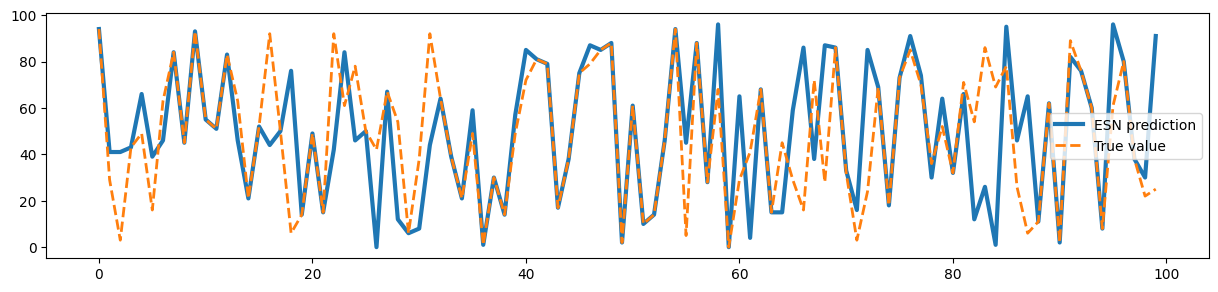

In [290]:
plot_results(Y_pred_class_avg[100:], Y_test_class_avg[100:])

In [246]:
states = []
spectral_radii = [0.1, 0.27, 1]
for i in spectral_radii:
    reservoir = Reservoir(
        units=1100, 
        sr=0.27, 
        input_scaling=0.9, 
        lr=i, 
        rc_connectivity=0.2,
        bias_scaling= 0.6
    )

    s = reservoir.run(X_val[10])
    states.append(s)

Running Reservoir-170: 100%|██████████| 34/34 [00:00<00:00, 1045.71it/s]


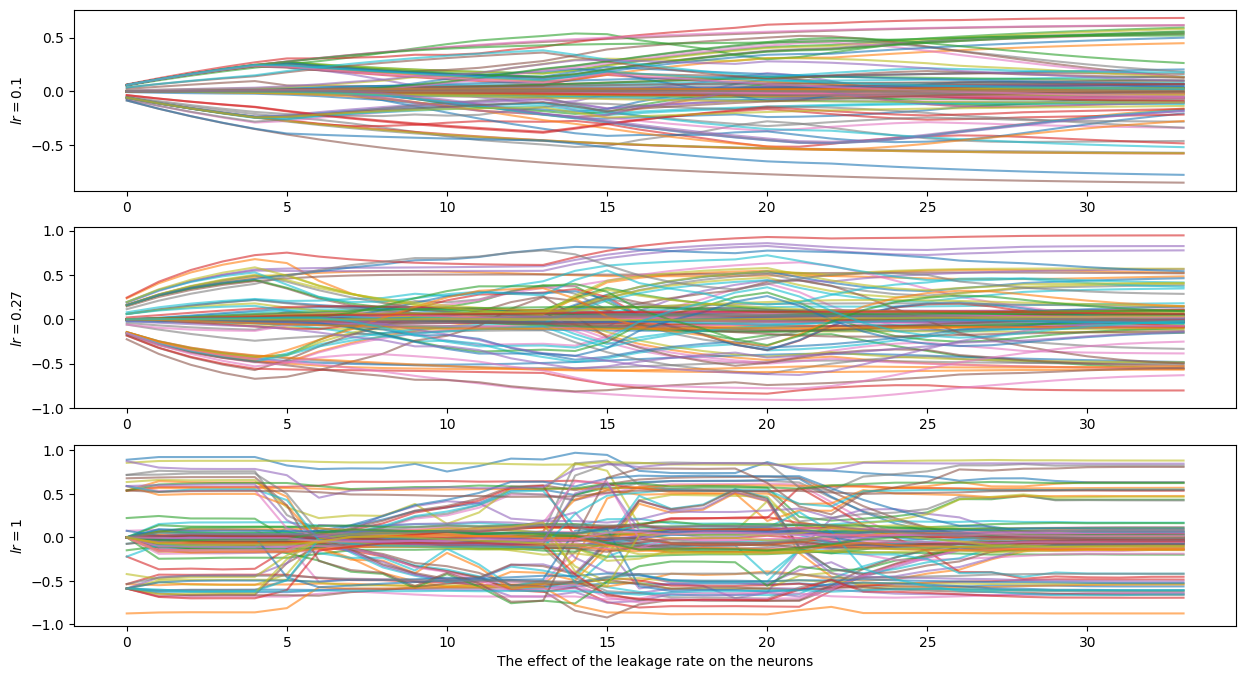

In [247]:
UNITS_SHOWN = 100

plt.figure(figsize=(15, 8))
for i, s in enumerate(states):
    plt.subplot(len(spectral_radii), 1, i+1)
    plt.plot(s[:, :UNITS_SHOWN], alpha=0.6)
    plt.ylabel(f"$lr={spectral_radii[i]}$")
plt.xlabel(f"The effect of the leakage rate on the neurons")
plt.show()

In [299]:
reservoir1 = Reservoir(800,lr=0.27,sr=0.25,input_scaling=0.9, rc_connectivity=0.3, bias_scaling= 0.6)
reservoir2 = Reservoir(800,lr=0.27,sr=0.25,input_scaling=0.9, rc_connectivity=0.3, bias_scaling= 0.6)
reservoir3 = Reservoir(800,lr=0.27,sr=0.25,input_scaling=0.9, rc_connectivity=0.3, bias_scaling= 0.6)

source = Input()

readout = Ridge(ridge= 1e-9)

deepESN = source >> [reservoir1, reservoir2, reservoir3] >> readout
rpy.verbosity(1)
Y_pred = deepESN.fit(X_train, Y_train , warmup=10, force_teachers=True).run(X_test, forced_feedbacks=Y_train, shift_fb=True)


Running Model-132: 34it [00:00, 426.19it/s]             /s]
Running Model-132: 34it [00:00, 305.24it/s][00:00<16:57,  4.76it/s]
Running Model-132: 34it [00:00, 357.59it/s]               4.52it/s]
Running Model-132: 34it [00:00, 436.81it/s]               4.88it/s]
Running Model-132: 34it [00:00, 481.59it/s]               5.31it/s]
Running Model-132: 34it [00:00, 477.69it/s]               5.64it/s]
Running Model-132: 34it [00:00, 500.10it/s]               5.76it/s]
Running Model-132: 34it [00:00, 492.12it/s]               5.97it/s]
Running Model-132: 34it [00:00, 465.90it/s]               5.95it/s]
Running Model-132: 34it [00:00, 513.08it/s]               6.18it/s]
Running Model-132: 34it [00:00, 465.20it/s]             ,  6.35it/s]
Running Model-132: 34it [00:00, 348.00it/s]             ,  6.20it/s]
Running Model-132: 34it [00:00, 456.13it/s]             ,  5.70it/s]
Running Model-132: 34it [00:00, 443.52it/s]             ,  5.72it/s]
Running Model-132: 34it [00:00, 383.43it/s]         

Running Model-132: 34it [00:00, 162.11it/s]
Running Model-132: 34it [00:00, 416.48it/s]             9,  4.19it/s]
Running Model-132: 34it [00:00, 487.97it/s]             3,  4.49it/s]
Running Model-132: 34it [00:00, 494.88it/s]             8,  5.04it/s]
Running Model-132: 34it [00:00, 417.49it/s]             0,  5.43it/s]
Running Model-132: 34it [00:00, 437.74it/s]             4,  5.53it/s]
Running Model-132: 34it [00:00, 381.39it/s]             6,  5.58it/s]
Running Model-132: 34it [00:00, 525.43it/s]             1,  5.62it/s]
Running Model-132: 34it [00:00, 490.95it/s]             3,  5.95it/s]
Running Model-132: 34it [00:00, 526.10it/s]             5,  6.09it/s]
Running Model-132: 34it [00:00, 590.16it/s]             7,  6.40it/s]
Running Model-132: 34it [00:00, 596.13it/s]             9,  6.65it/s]
Running Model-132: 34it [00:00, 498.78it/s]             8,  6.76it/s]
Running Model-132: 34it [00:00, 553.36it/s]             4,  6.70it/s]
Running Model-132: 34it [00:00, 395.32it/s]   

Fitting node Ridge-48...


Running Model-132: 34it [00:00, 287.04it/s]             
Running Model-132: 34it [00:00, 417.82it/s]             
Running Model-132: 34it [00:00, 424.82it/s]             
Running Model-132: 34it [00:00, 391.49it/s]             
Running Model-132: 34it [00:00, 427.88it/s]             
Running Model-132: 34it [00:00, 417.02it/s]             
Running Model-132: 34it [00:00, 430.87it/s]             
Running Model-132: 34it [00:00, 405.33it/s]             
Running Model-132: 34it [00:00, 448.29it/s]             
Running Model-132: 34it [00:00, 436.17it/s]             
Running Model-132: 34it [00:00, 434.57it/s]             
Running Model-132: 34it [00:00, 456.97it/s]             
Running Model-132: 34it [00:00, 457.73it/s]             
Running Model-132: 34it [00:00, 452.71it/s]             
Running Model-132: 34it [00:00, 456.65it/s]             
Running Model-132: 34it [00:00, 373.84it/s]             
Running Model-132: 34it [00:00, 434.18it/s]             
Running Model-132: 34it [00:00,

In [300]:
Y_pred_class = [np.argmax(y_p, axis=1) for y_p in Y_pred]
Y_test_class = [np.argmax(y_t, axis=1) for y_t in Y_test]

score = accuracy_score(np.concatenate(Y_test_class, axis=0), np.concatenate(Y_pred_class, axis=0))

print("Accuracy: ", f"{score * 100:.3f} %")


# The majority voting (averaging across time before argmax) gets better accuracy
Y_pred_class_avg = [np.argmax( np.average(y_p, axis=0) ) for y_p in Y_pred]
Y_test_class_avg = [np.argmax( np.average(y_t, axis=0) ) for y_t in Y_test]

score_avg = accuracy_score(Y_test_class_avg, Y_pred_class_avg)

print("Accuracy: ", f"{score_avg * 100:.3f} %")

report = classification_report(Y_test_class_avg, Y_pred_class_avg, zero_division=1)
#print(report)
#49.4

Accuracy:  43.891 %
Accuracy:  69.265 %


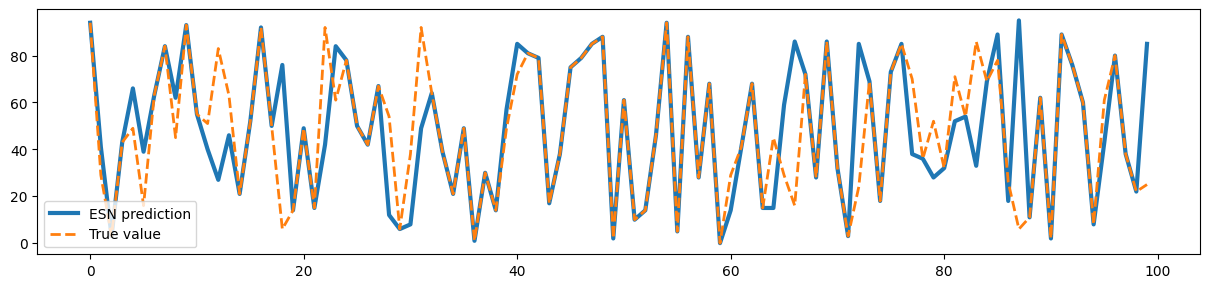

In [301]:
plot_results(Y_pred_class_avg[100:], Y_test_class_avg[100:])

In [ ]:
conf_matrix = confusion_matrix(Y_test_class_avg, Y_pred_class_avg)

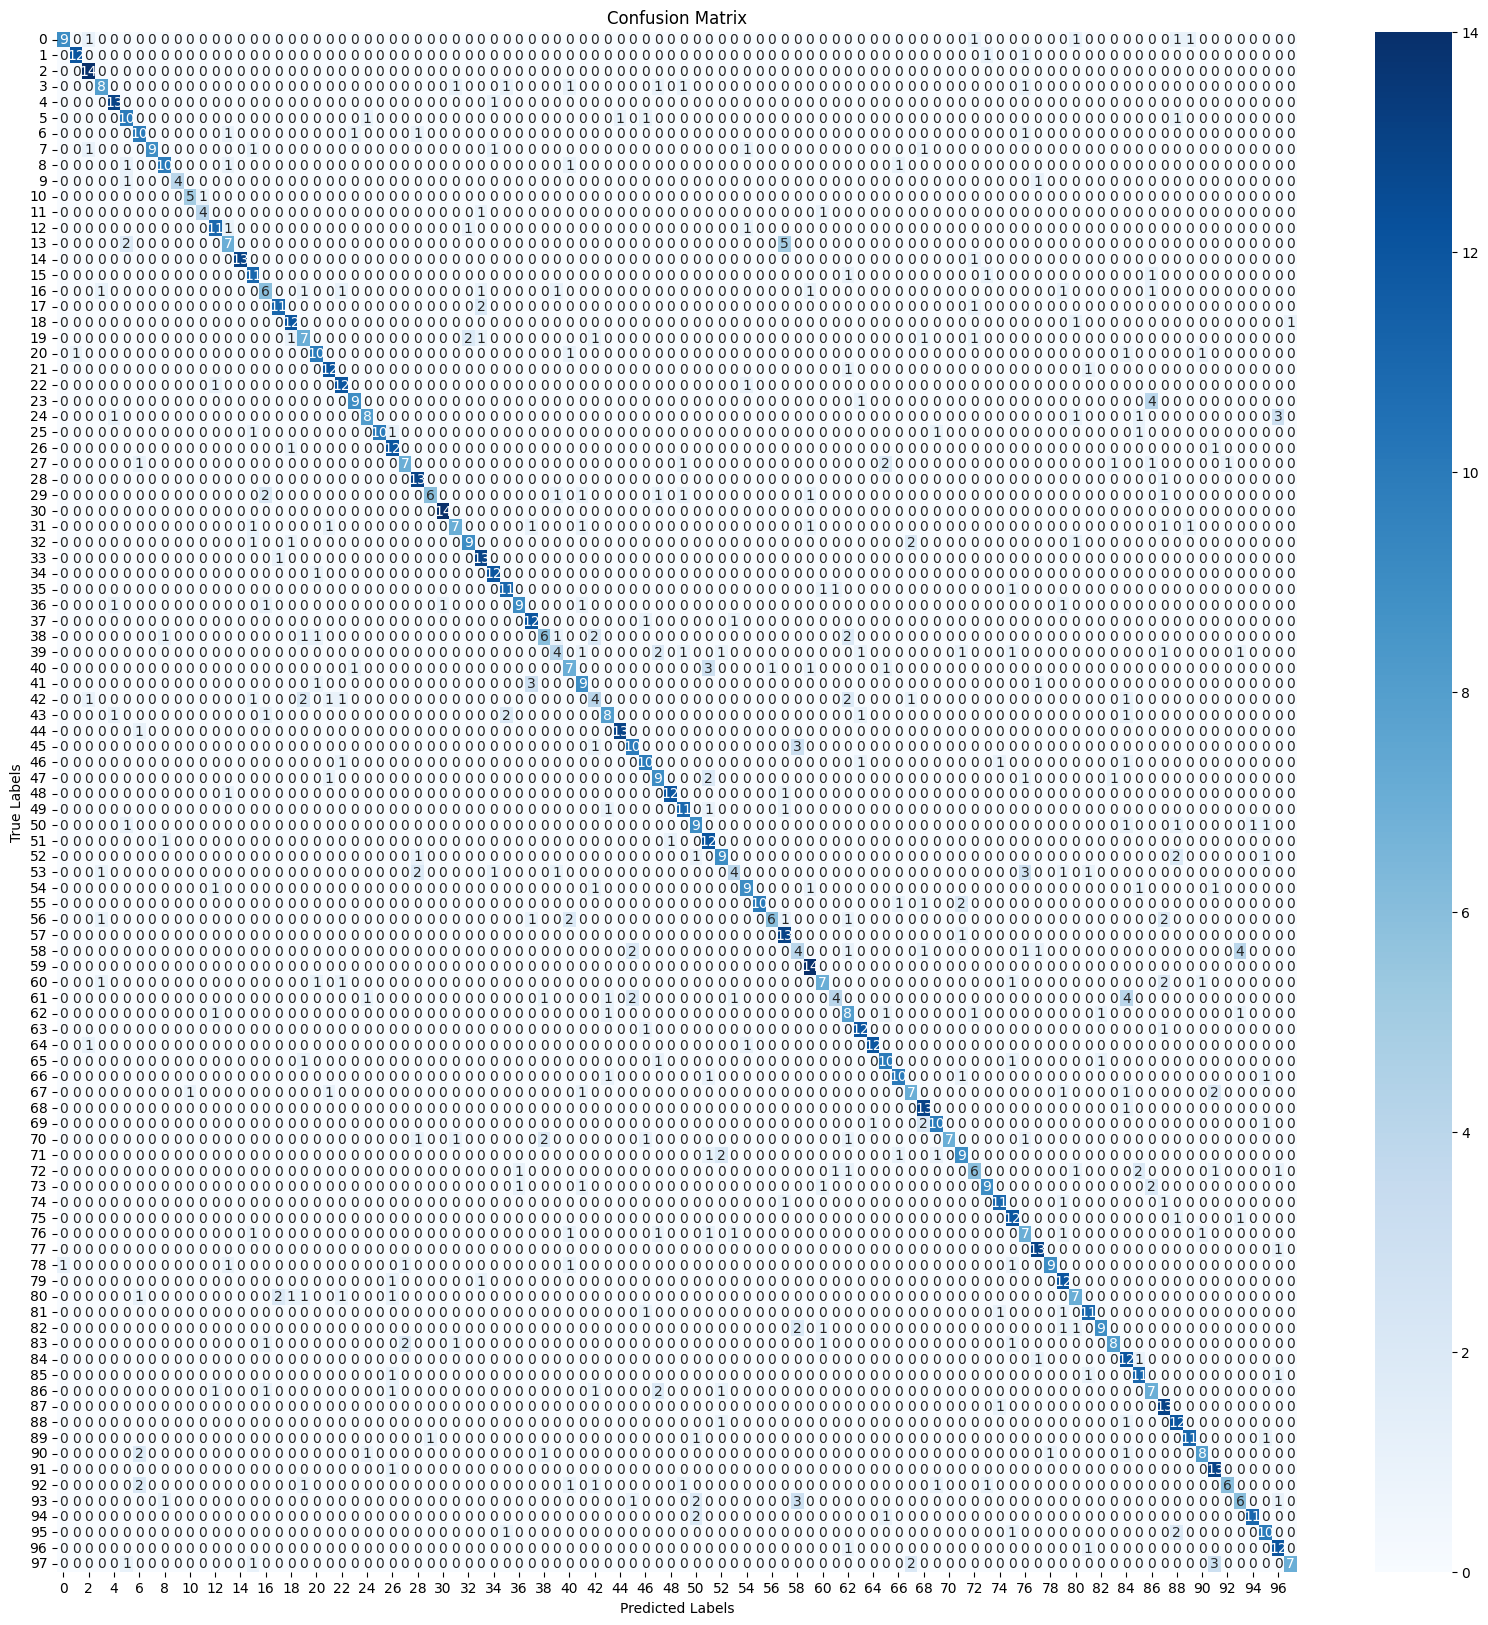

In [ ]:
import seaborn as sns
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()